In [1]:
using DiffEqOperators
using BandedMatrices
using LinearAlgebra
using LazyArrays

order = 2
deriv = 2
Δx = 0.1
N = 9
v = rand(N);
A = CenteredDifference{1}(deriv, order, Δx, N) + CenteredDifference{2}(deriv, order, Δx, N)
T = BandedMatrix(CenteredDifference(2, 2, Δx, N))
Pair{<:Integer,<:AbstractVector}
D = similar(T)
for i = 1:9
    D[i,i+1] = 10.
end
D

┌ Info: Precompiling DiffEqOperators [9fdde737-9c7f-55bf-ade8-46b3f136cc48]
└ @ Base loading.jl:1242
┌ Warning: Replacing docs for `DiffEqOperators.PeriodicBC :: Union{}` in module `DiffEqOperators`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `DiffEqOperators.RobinBC :: Union{}` in module `DiffEqOperators`
└ @ Base.Docs docs\Docs.jl:223


9×11 BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}:
 4.94066e-324  10.0           …    ⋅              ⋅     ⋅    ⋅ 
 0.0            0.0                ⋅              ⋅     ⋅    ⋅ 
 0.0            0.0                ⋅              ⋅     ⋅    ⋅ 
 4.94066e-324   0.0               1.18572e-315    ⋅     ⋅    ⋅ 
 4.94066e-324   4.94066e-324      1.18572e-315   0.0    ⋅    ⋅ 
  ⋅             0.0           …   1.18572e-315   0.0   0.0   ⋅ 
  ⋅              ⋅               10.0            0.0   0.0  0.0
  ⋅              ⋅                1.18574e-315  10.0   0.0  0.0
  ⋅              ⋅                1.18574e-315   0.0  10.0  0.0

In [2]:
###########
# This gives an example of Gauss–Seidel
#
###########

using BlockBandedMatrices, BandedMatrices, FillArrays, ArrayLayouts, SparseArrays
using LinearAlgebra
using LazyArrays
using LazyBandedMatrices

function finitedifference_2d(n)
    h = 1/n
    D² = BandedMatrix(0 => Fill(-2,n), 1 => Fill(1,n-1), -1 => Fill(1,n-1))/h^2
    D_xx = BandedBlockBandedMatrix(Kron(D², Eye(n)))
    print(size(D_xx))
    D_yy = BandedBlockBandedMatrix(Kron(Eye(n), D²))
    D_xx + D_yy
end

function finitedifference_2d_test(n)
    h = 1/n
    D = BandedBlockBandedMatrix(Zeros(n^2,n^2), (Fill(n,n), Fill(n,n)), (1,1), (1,1))
    Id = BandedBlockBandedMatrix(I, (Fill(n,n), Fill(n,n)), (1,1), (1,1))
    D² = BandedMatrix(0 => Fill(-2,n), 1 => Fill(1,n-1), -1 => Fill(1,n-1))/h^2
    view(D,Block(1,1))[band(0)] .= -2
    view(D,Block(1,1))[band(1)] .= 1
    view(D,Block(1,1))[band(-1)] .= 1
    for K = 2:n
      view(D,Block(K,K))[band(1)] .= 1
      view(D,Block(K,K))[band(0)] .= -2
      view(D,Block(K,K))[band(-1)] .= 1
      view(D,Block(K,K-1))[band(0)] .= 1
      view(D,Block(K-1,K))[band(0)] .= 1
    end
    #D_xx = BandedBlockBandedMatrix(Kron(D², Eye(n)))
    #print(size(D_xx))
    #D_yy = BandedBlockBandedMatrix(Kron(Eye(n), D²))
    #D_xx + D_yy
    D - Id
end

function _gaussseidel(L, U, b, x=copy(b), y=copy(b), M=5)
    for _=1:M
        @view(y[1:end-1]) .= Mul(U , @view(x[2:end]))
        y[end] = 0
        x .= b .- y
        x .= Ldiv(L, x)
    end
    x
end

function _gaussseidel2(L, U, b, x=copy(b), y=copy(b), M=5)
    for _=1:M
        mul!(@view(y[1:end-1]) , U , @view(x[2:end]))
        y[end] = 0
        y .= b .- y
        x .= L\ y
    end
    x
end

function gaussseidel(A, b, M)
    n = Int(sqrt(length(b)))
    L = LowerTriangular(A)
    U = BandedBlockBandedMatrix(UpperTriangular(@view(A[1:end-1,2:end])), ([fill(n,n-1); n-1], [n-1; fill(n,n-1)]),
                                            (0,1), (0,1))
    x = copy(b)
    _gaussseidel(L,U, b, x, copy(x), M) # 1.6s
    x
end

gaussseidel (generic function with 1 method)

In [3]:
#finitedifference_2d(5)
n = 200;
using BandedMatrices
b1 = BandedMatrix(0 => Fill(1.,n))
b2 = 2*copy(b1)
b1

@time finitedifference_2d_test(n)

  6.954917 seconds (17.47 M allocations: 784.097 MiB, 5.24% gc time)


200×200-blocked 40000×40000 BandedBlockBandedMatrix{Float64,BlockArrays.PseudoBlockArray{Float64,2,Array{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 -3.0   1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  1.0  -3.0   1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅    1.0  -3.0   1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅    1.0  -3.0   1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅    1.0  -3.0   1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅    1.0  -3.0  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅    1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅ 

In [4]:
Nx = 3; 

A = BandedBlockBandedMatrix(Zeros(Nx^2,Nx^2), (Fill(Nx,Nx), Fill(Nx,Nx)), (1,1), (1,1));

for K = 1:Nx
  view(A,Block(K,K))[band(1)] .= 1
  view(A,Block(K,K))[band(0)] .= -4
  view(A,Block(K,K))[band(-1)] .= 1
end

A

3×3-blocked 9×9 BandedBlockBandedMatrix{Float64,BlockArrays.PseudoBlockArray{Float64,2,Array{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 -4.0   1.0    ⋅   │   0.0   0.0    ⋅   │    ⋅     ⋅     ⋅ 
  1.0  -4.0   1.0  │   0.0   0.0   0.0  │    ⋅     ⋅     ⋅ 
   ⋅    1.0  -4.0  │    ⋅    0.0   0.0  │    ⋅     ⋅     ⋅ 
 ──────────────────┼────────────────────┼──────────────────
  0.0   0.0    ⋅   │  -4.0   1.0    ⋅   │   0.0   0.0    ⋅ 
  0.0   0.0   0.0  │   1.0  -4.0   1.0  │   0.0   0.0   0.0
   ⋅    0.0   0.0  │    ⋅    1.0  -4.0  │    ⋅    0.0   0.0
 ──────────────────┼────────────────────┼──────────────────
   ⋅     ⋅     ⋅   │   0.0   0.0    ⋅   │  -4.0   1.0    ⋅ 
   ⋅     ⋅     ⋅   │   0.0   0.0   0.0  │   1.0  -4.0   1.0
   ⋅     ⋅     ⋅   │    ⋅    0.0   0.0  │    ⋅    1.0  -4.0

In [5]:
n = 1000;
Δt = (1/n^2)/4; 

@time Δ = finitedifference_2d(n);
@time A = I - Δt*Δ  # 1m x 1m discretization
b = randn(n^2)
L = LowerTriangular(A)
@time U = BandedBlockBandedMatrix(UpperTriangular(@view(A[1:end-1,2:end])), ([fill(n,n-1); n-1], [n-1; fill(n,n-1)]),
                                        (0,1), (0,1))
x = copy(b)
y = copy(x)
@time _gaussseidel(L,U, b, x, y, 20) # 0.4s

@time L̃ = sparse(BandedBlockBandedMatrix(L))
@time Ũ = sparse(U)
x = copy(b)
y = copy(x)
@time _gaussseidel2(L̃,Ũ, b, x, y, 20)

#=
Ã = sparse(A)
@time qr(Ã);
@time Ã \b ;

A = randn(n,n)

n = 1000;
    As = [randn(2k+1,k) for k=1:n];

    @time for A in As
        qr(A)
    end
n = 1000;
    # As = [randn(2k+1,k) for k=1:n];

    @time for A in As
        lu(A)
    end

0.02*n
=#

(1000000, 1000000)  7.023606 seconds (36.10 M allocations: 1.991 GiB, 9.56% gc time)
  1.386930 seconds (6.69 M allocations: 573.372 MiB, 16.17% gc time)
  1.256846 seconds (20.19 M allocations: 1.383 GiB, 11.06% gc time)
  6.257076 seconds (9.42 M allocations: 452.671 MiB, 3.73% gc time)
  2.630093 seconds (31.35 M allocations: 2.571 GiB, 19.86% gc time)
  0.529952 seconds (18.05 k allocations: 368.070 MiB, 50.03% gc time)
  2.198715 seconds (4.56 M allocations: 374.844 MiB, 9.39% gc time)


1000000-element Array{Float64,1}:
 -0.273801966701004   
 -0.5581072747823461  
  0.08798744257996102 
 -0.6735076179807108  
 -0.7142173399584678  
 -0.6941527365078184  
  0.32505011784169846 
  0.07118191397160434 
 -0.09464542232060386 
  0.08306115928007168 
 -0.048591535472060375
 -0.39775821695291125 
 -0.6859463915549139  
  ⋮                   
  0.30506377591768624 
  0.5816303319338024  
  0.021107702034665957
 -0.5461507505094942  
 -0.17277925413423356 
 -0.8018530275620703  
 -0.8393291655910169  
 -0.9650549052468137  
 -0.7608609280186734  
 -0.5860370094932068  
  0.019687785639934133
 -0.3626708803167068  

In [ ]:
A*x - b



x̃ = copy(x)
ỹ = copy(y)

@view(y[1:end-1]) .= Mul(U , @view(x[2:end]))

mul!(@view(ỹ[1:end-1]) , Ũ , @view(x̃[2:end]))
y[end] = 0
ỹ[end] = 0
x = copy(b)
    y = copy(x)
    _gaussseidel(L,U, b, x, y, 1) - x_bb

x .= b .- y
ỹ .= b .- ỹ
x .= Ldiv(L, x)

x̃ .= L̃ \ ỹ


x - x_bb

x̃-x



(L̃ \ x) - (L \ x)

ỹ - y |> norm
x - x_bb

A*x - b


L̃ == L
Ũ == U

norm(A*x - b)
@time


@time copy(x)
L̃ = sparse(L)
Ũ = sparse(U)




y = x[1:end-1]
z = similar(y)
@time z .= Mul(U,y)
y = similar(x)
@time (@view(y[1:end-1]) .= Mul(U , @view(x[2:end])))
y[end] = 0
@time x .= b .- y
@time x .= Ldiv(L, x)
A = randn(9,40_000);
    @time A*x;

A
S = sparse(A);

400^2

@time L\x


h = 1/n
    @time D² = BandedMatrix(0 => Fill(-2,n), 1 => Fill(1,n-1), -1 => Fill(1,n-1))/h^2
    @time D_xx = BandedBlockBandedMatrix(Kron(D², Eye(n)))
    @time D_yy = BandedBlockBandedMatrix(Kron(Eye(n), D²))
    @time D_xx .+ D_yy
    4



using Profile
dest = Δ;
    @time BlockBandedMatrices.blockbanded_copyto!(dest, D_yy)
    view(dest, Block(1,1)) .= view(dest, Block(1,1)) .+ view(D_yy, Block(1,1))
D_yy
@time copyto!(dest, Broadcast.broadcasted(+, D_xx , D_yy))


using FFTW
A = randn(400, 400);
    @time fft(A);
dest[Block(1,1)]

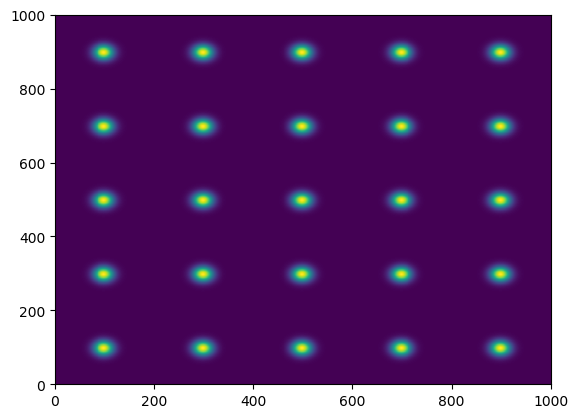

PyObject <matplotlib.collections.QuadMesh object at 0x000000006945FB70>

In [6]:
using PyPlot
n = 1000
Δt = 10000(1/n^2)/4; 
σx = 20;
σy = 20;
array = 5;
dn = n/array;

function bi(i,j)
    return b = [exp(-(x-i)^2/σx^2 - (y-j)^2/σy^2) for x in 1:n, y in 1:n]
end

b = zeros(n,n)

for i in 1:array, j in 1:array
    b += bi(dn*(i-1/2),dn*(j-1/2));
end

pcolormesh(b)

(1000000, 1000000)  1.123218 seconds (24.06 M allocations: 1.456 GiB, 24.60% gc time)
  0.493667 seconds (4.10 M allocations: 447.630 MiB, 43.30% gc time)
  0.799841 seconds (18.98 M allocations: 1.325 GiB, 15.18% gc time)
  1.966741 seconds (29.99 M allocations: 2.518 GiB, 25.93% gc time)
  0.556044 seconds (18.05 k allocations: 368.070 MiB, 53.98% gc time)

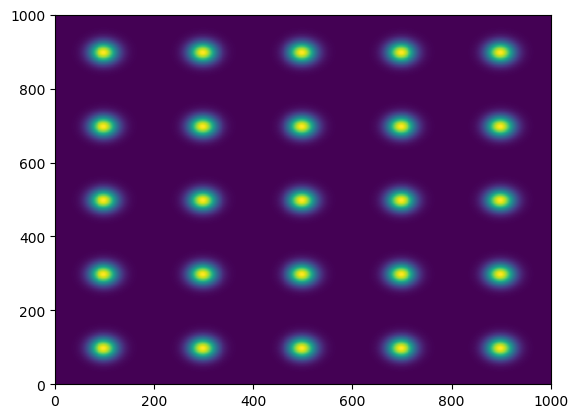


  6.074000 seconds (1.00 k allocations: 1.490 GiB, 4.95% gc time)


89.18750863532622

In [9]:
c = reshape(b,n^2)
@time Δ = finitedifference_2d(n);
@time A = I - Δt*Δ  # 1m x 1m discretization
L = LowerTriangular(A)
@time U = BandedBlockBandedMatrix(UpperTriangular(@view(A[1:end-1,2:end])), ([fill(n,n-1); n-1], [n-1; fill(n,n-1)]),
                                        (0,1), (0,1))
@time L̃ = sparse(BandedBlockBandedMatrix(L))
@time Ũ = sparse(U)
x = copy(c)
y = copy(x)
f = @time _gaussseidel2(L̃,Ũ, c, x, y, 200)
r = reshape(f,(n,n))
pcolormesh(r)
norm(f)

In [10]:
norm(c)

125.33141373155001

In [ ]:
Int.(ones(1,N))

In [ ]:
T = Array{Int64,1}(undef,4)
3 .+ T

In [ ]:
finitedifference_2d(n)